In [2]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
sys.path.append("../")

import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import numpy as np
import cv2
import json
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from model import build_model
from clip_ import load, tokenize, similarity_score
from vit_cam import interpret_vit, interpret_vit_overlapped, vit_relevance
from rn_cam import interpret_rn, interpret_rn_overlapped, rn_relevance
sys.path.append("../pytorch-grad-cam")
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from pickle_loader import Pickle_data_loader

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
model_rn, preprocess = load("RN101", device=device, jit=False)
model_vit, preprocess = load("ViT-B/32", device=device, jit=False)

In [5]:
model_types = ["ViT", "RN101"] 

font = {
    'size': 15,
}

ori_preprocess = Compose([
        Resize((224), interpolation=Image.BICUBIC),
        CenterCrop(size=(224, 224)),
        ToTensor()])

emotion_dict = json.load(open("ARTEMIS_EMOTIONS.json"))
artemis_labels = emotion_dict.keys()

ARTEMIS_EMOTIONS = { 'amusement':0,
                     'awe':1,
                     'contentment':2,
                     'excitement':3,
                     'anger':4,
                     'disgust':5,
                     'fear':6,
                     'sadness':7,
                     'something else':8}

root = "../../Images/"
res_dir = "../../results/artemis_emotions/"

if not os.path.exists(res_dir):
    os.mkdir(res_dir)

# Saliency visualization for Artemis images 

In [6]:
image_loader = Pickle_data_loader(root+"wikiart/", 40)
for i,batch in enumerate(image_loader):
    if i==0:
        image_list = batch["image"]
        label_list = batch["label"]
    else:
        image_list = torch.cat((image_list, batch["image"]), dim=0)
        label_list = torch.cat((label_list, batch["label"]), dim=0)

/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


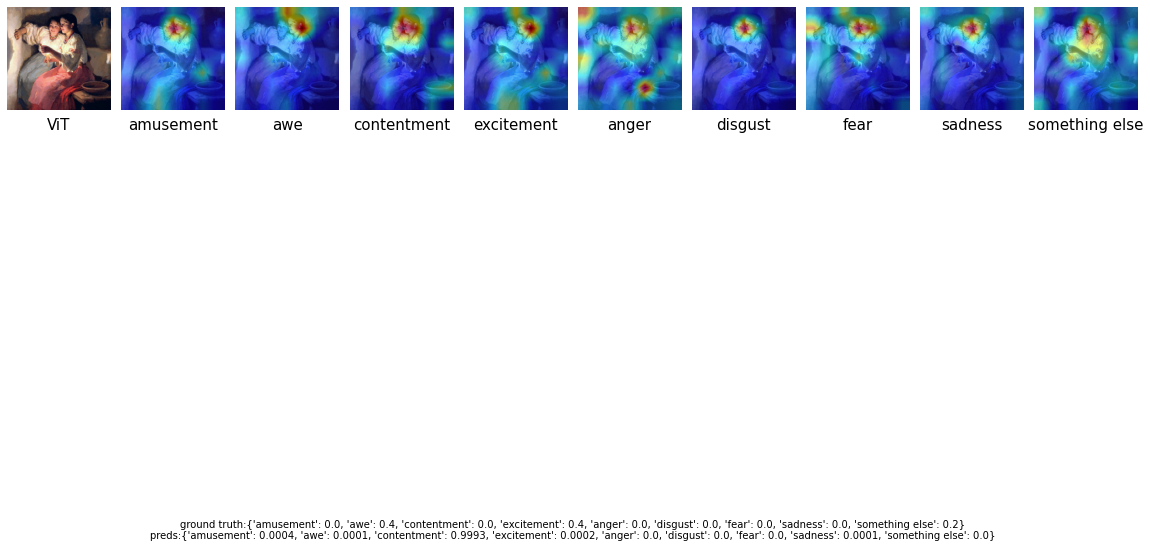

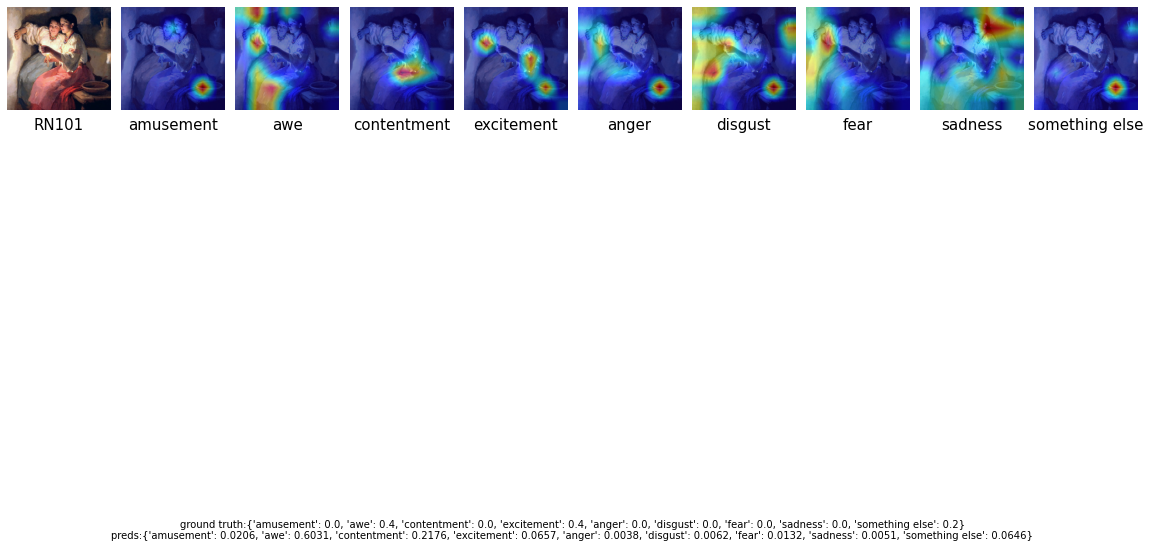

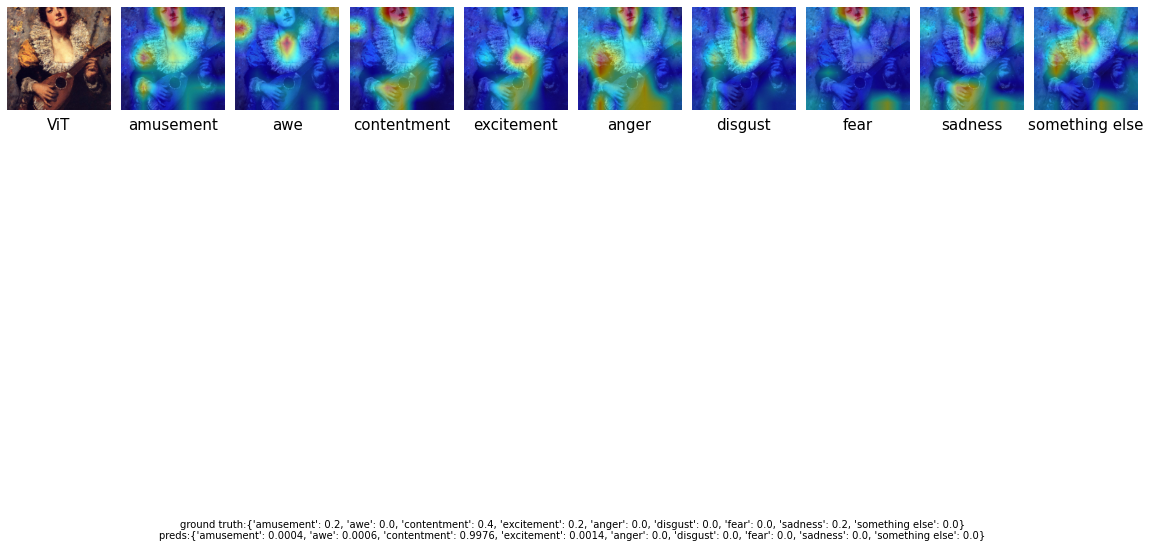

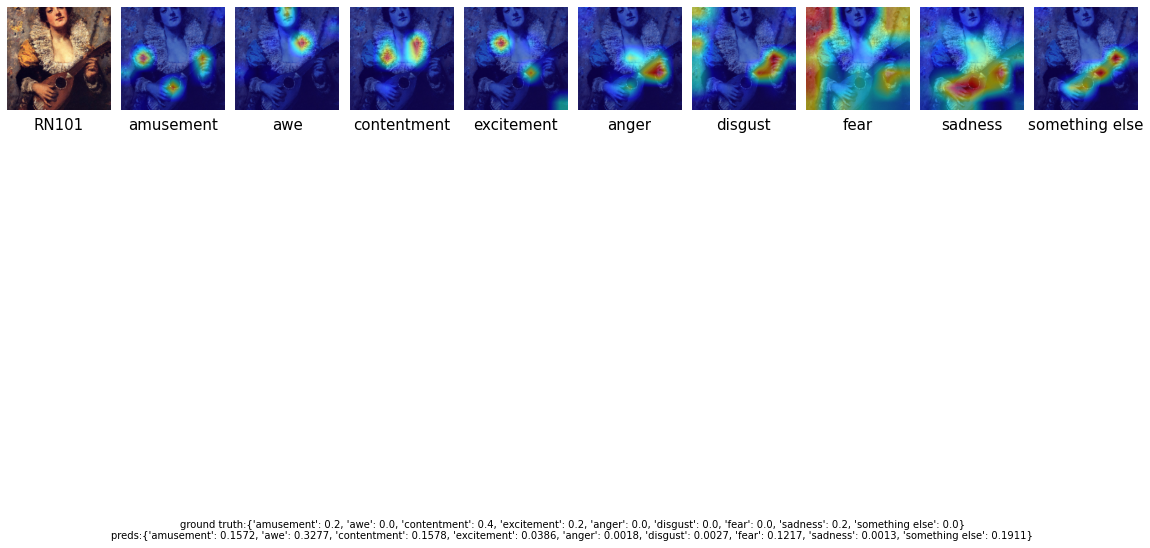

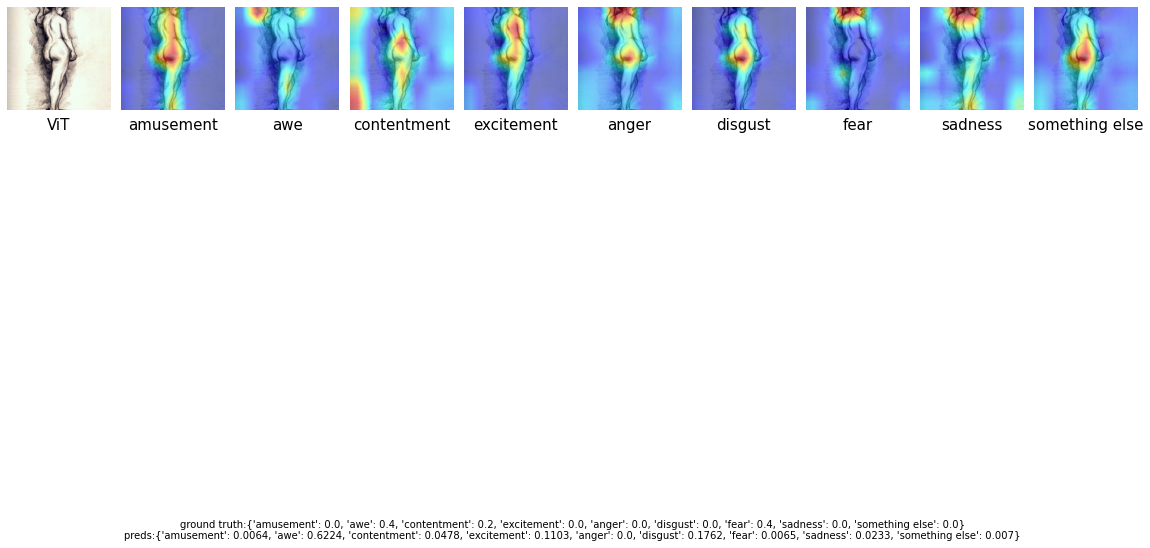

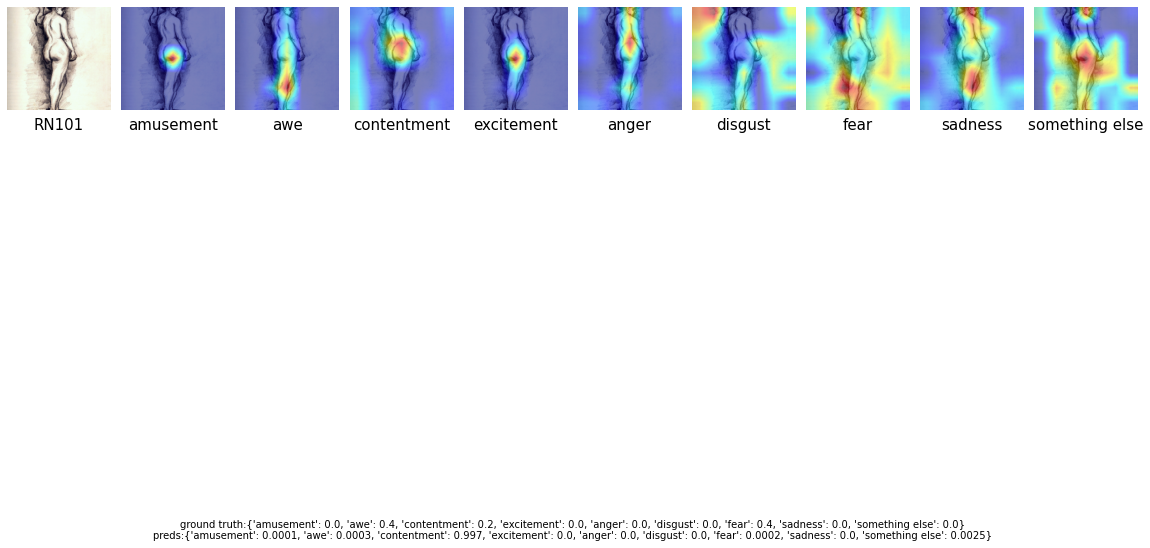

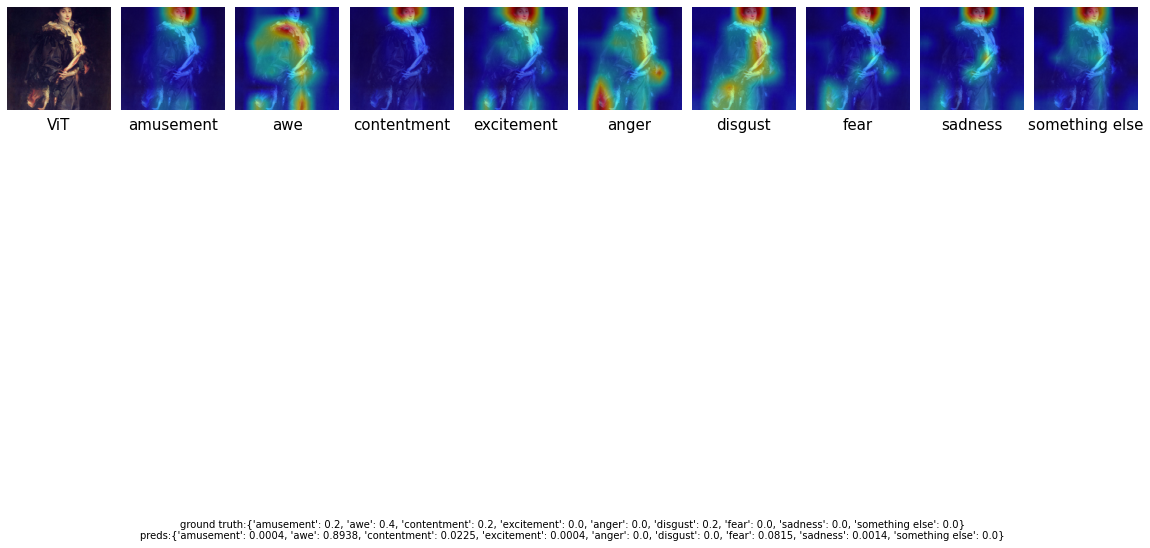

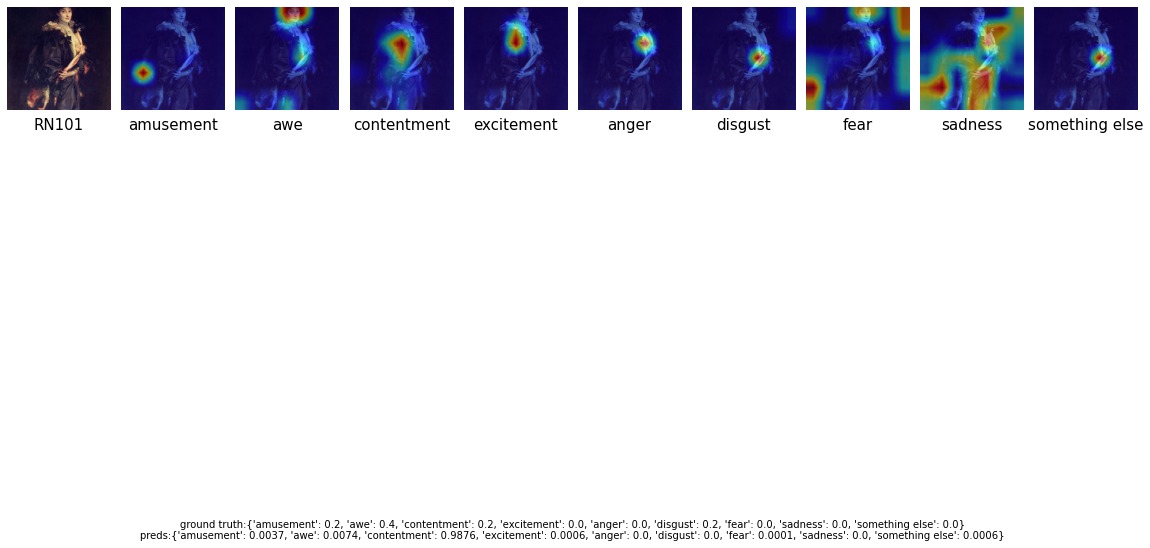

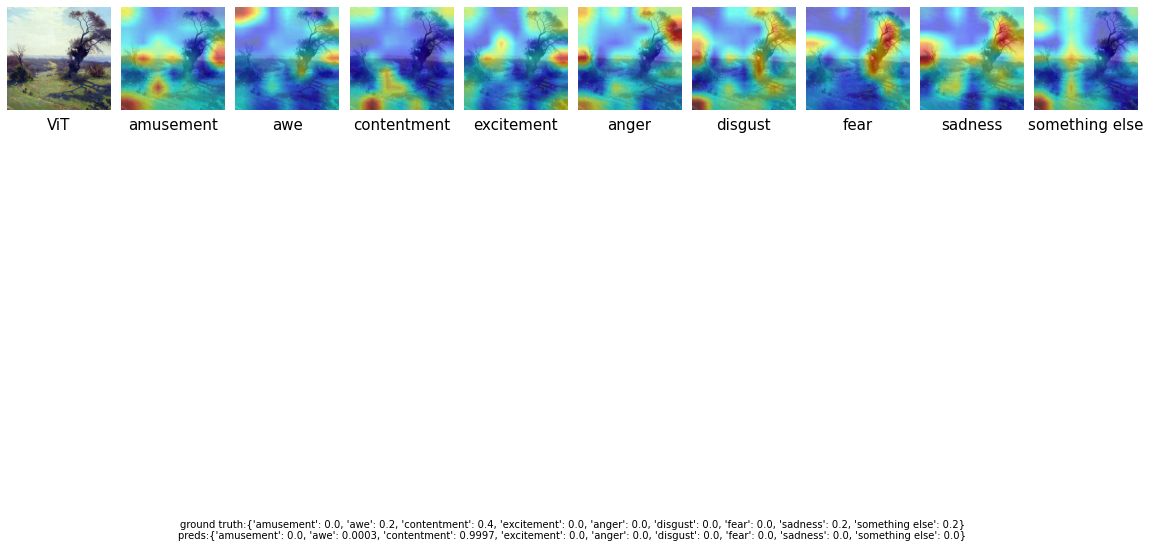

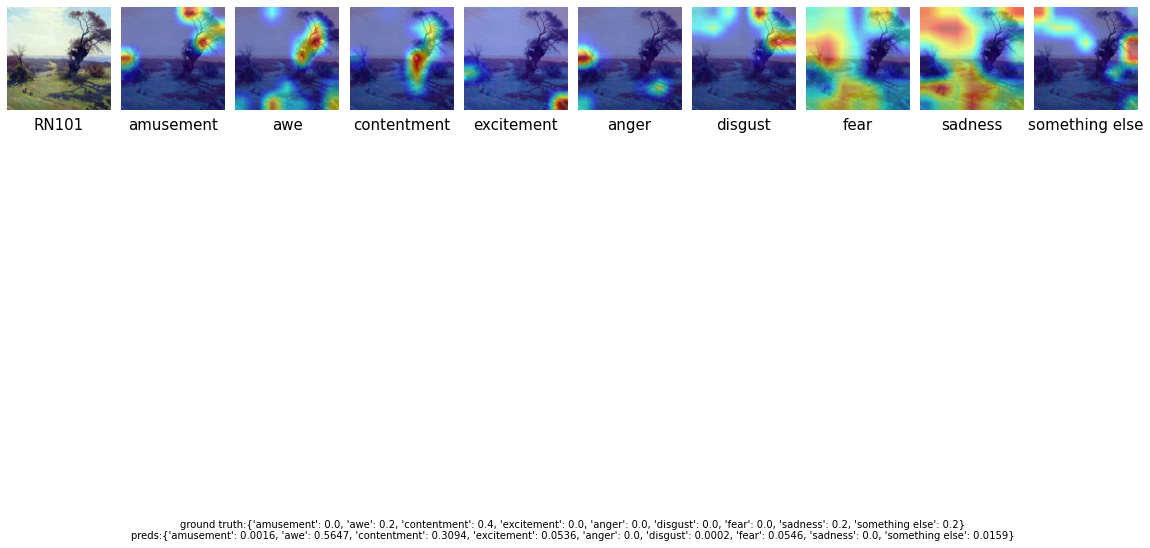

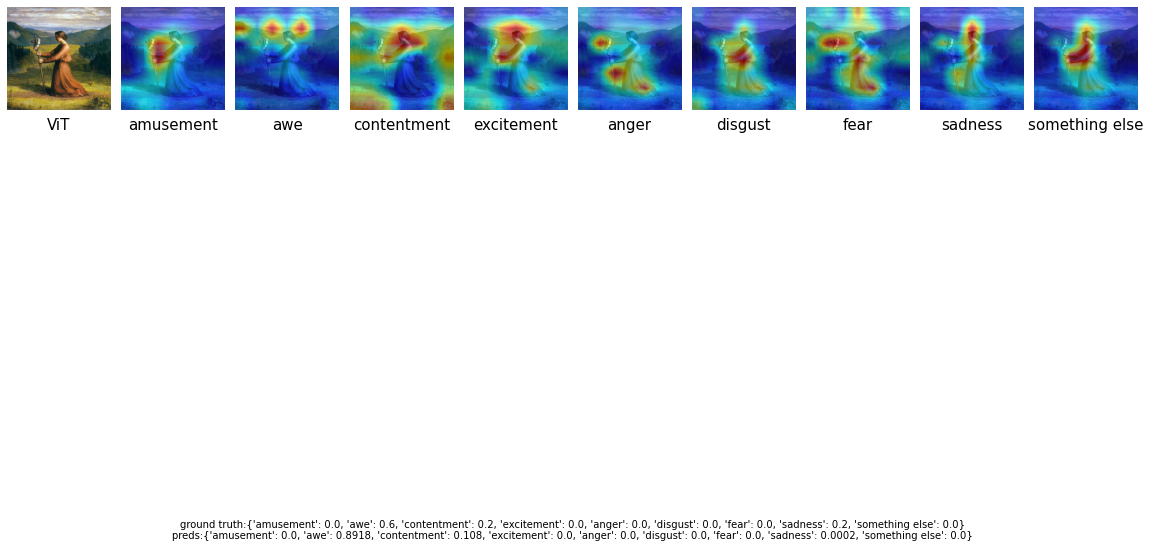

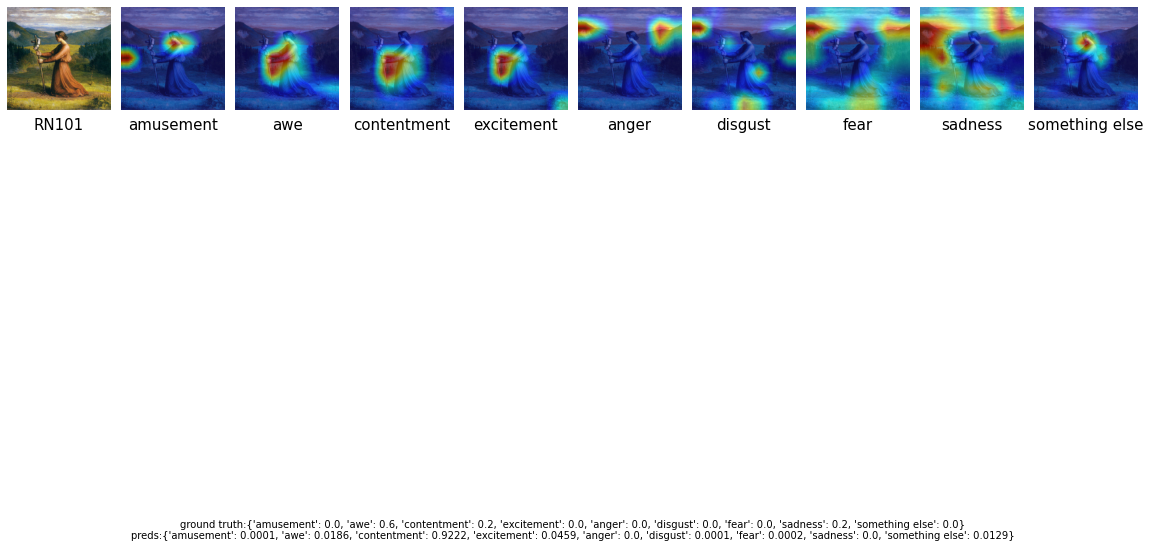

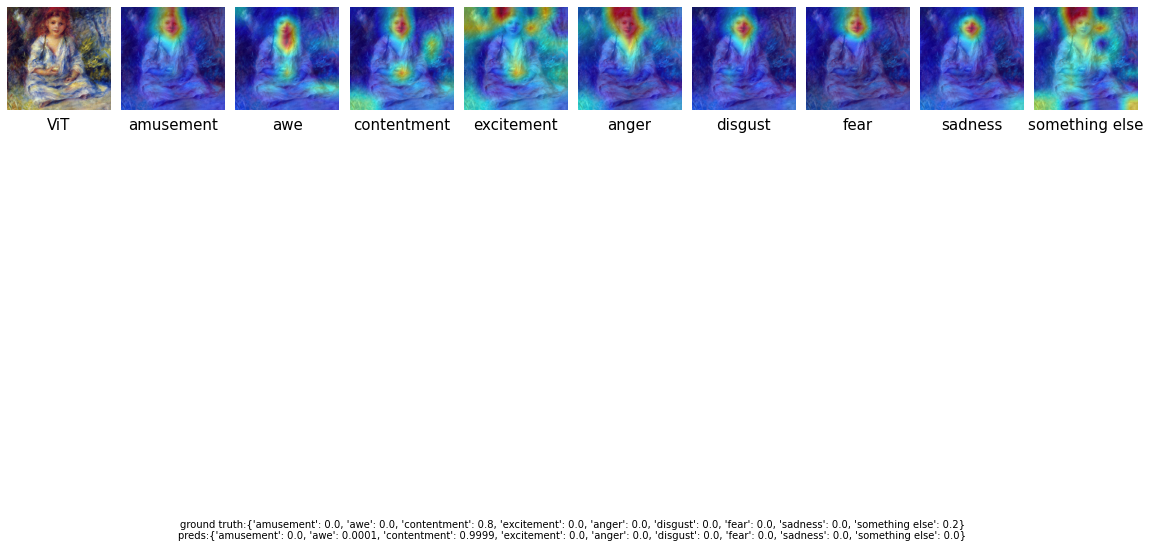

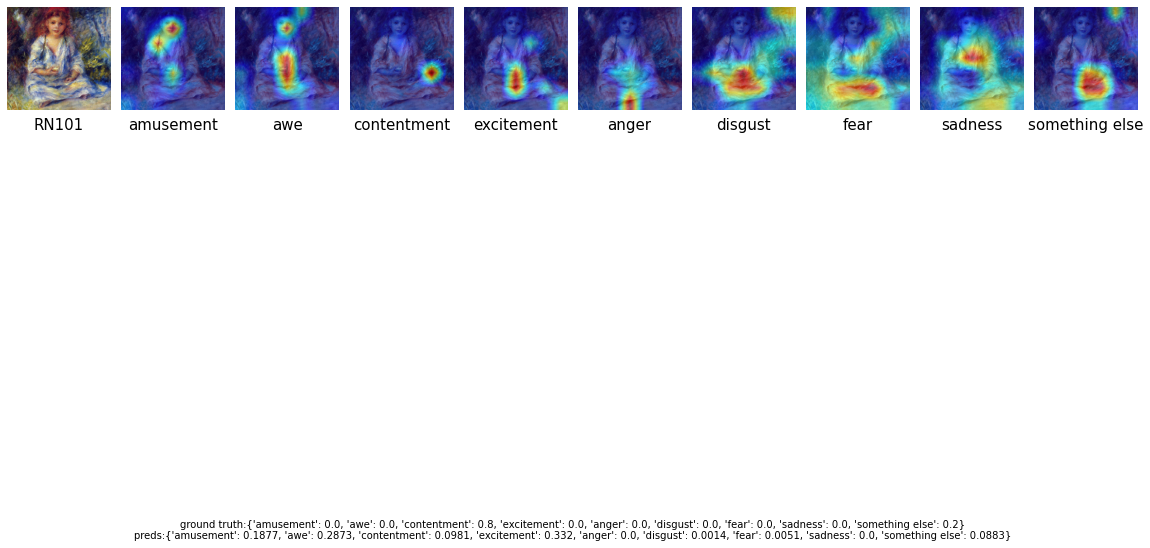

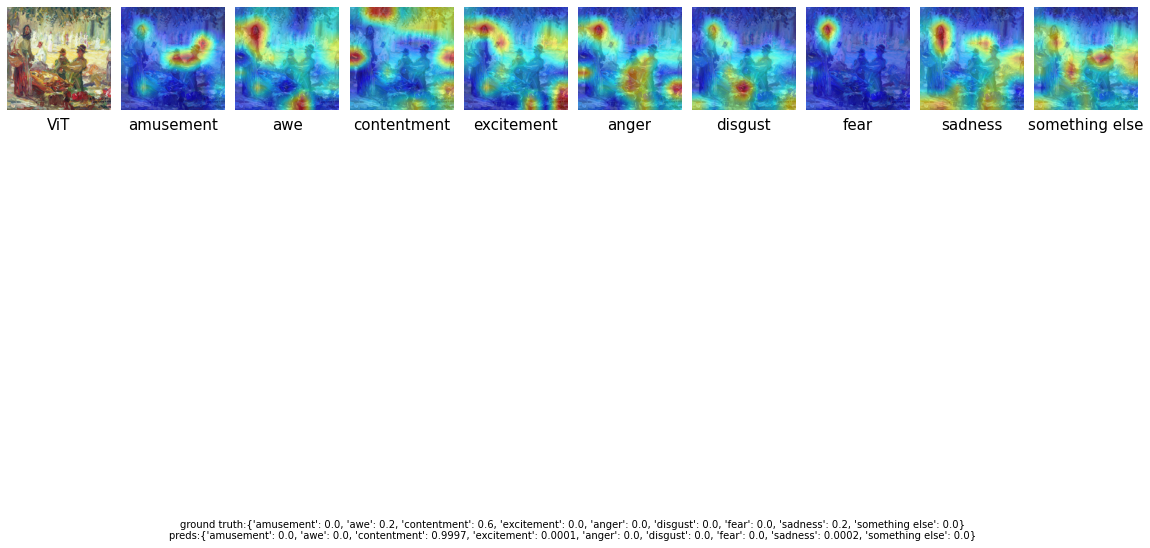

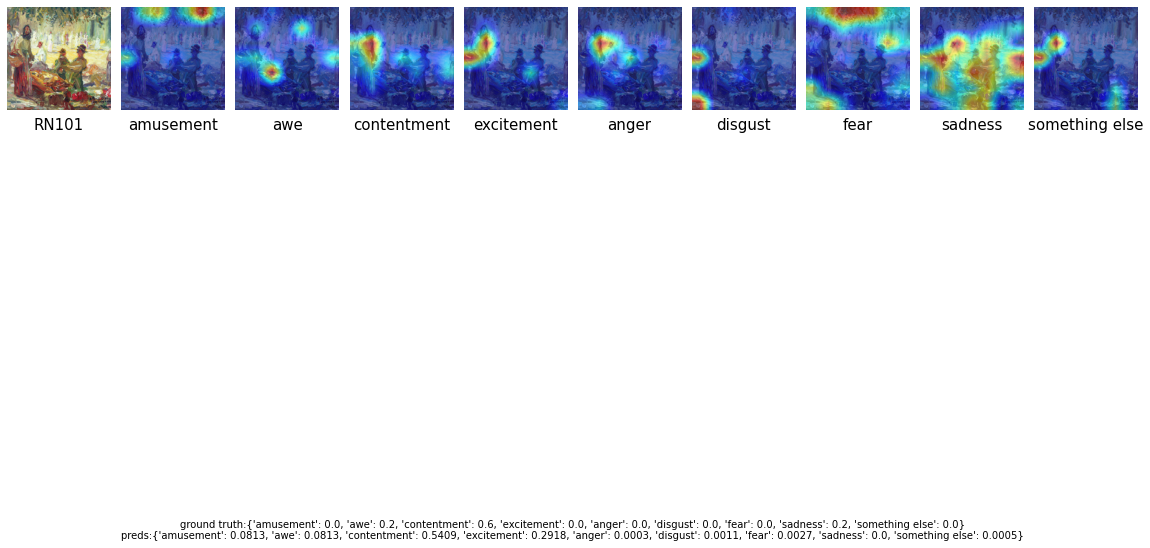

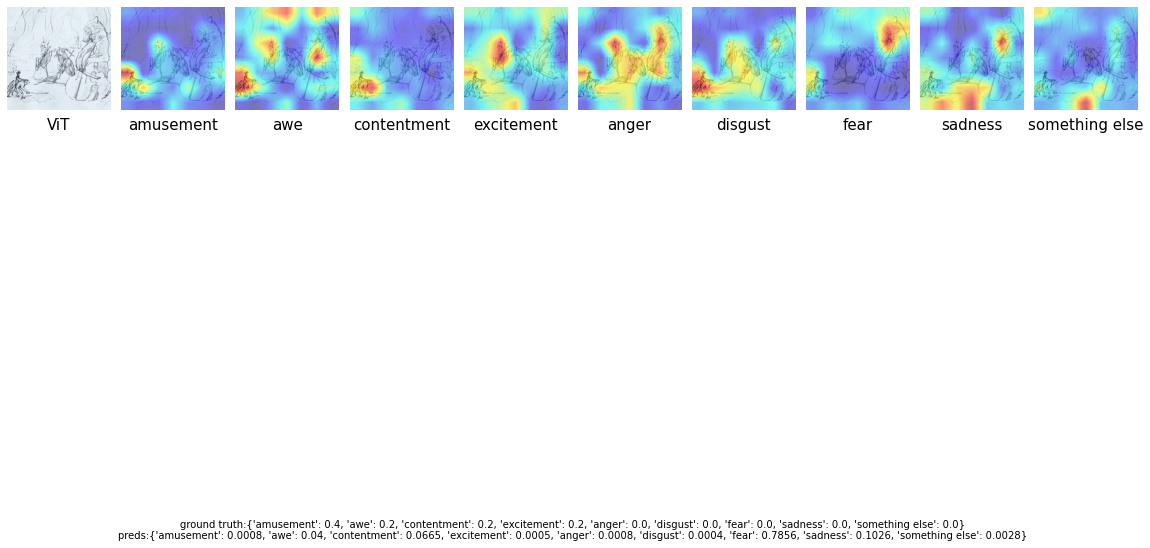

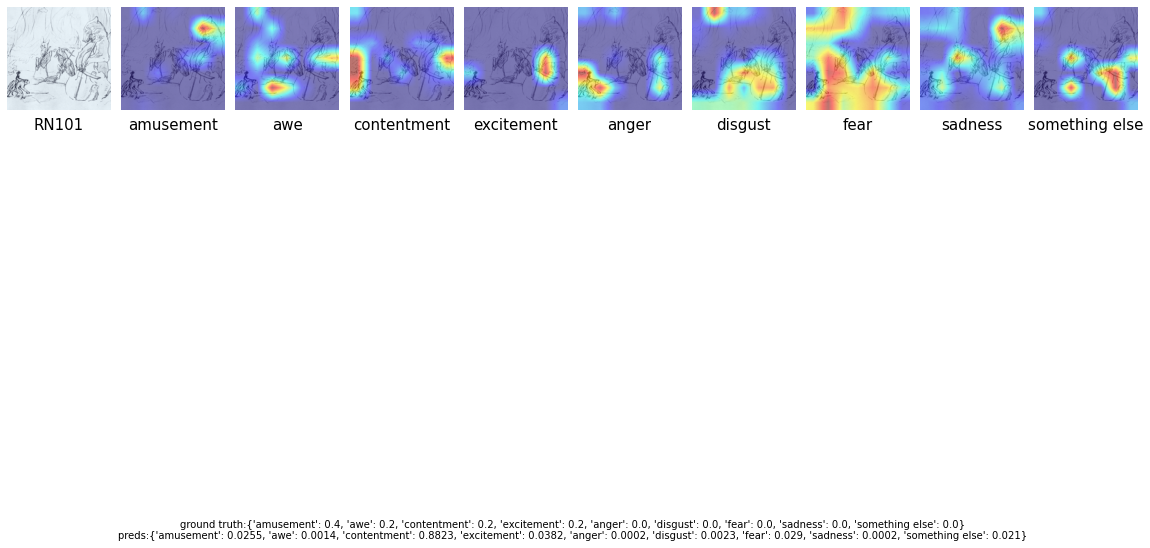

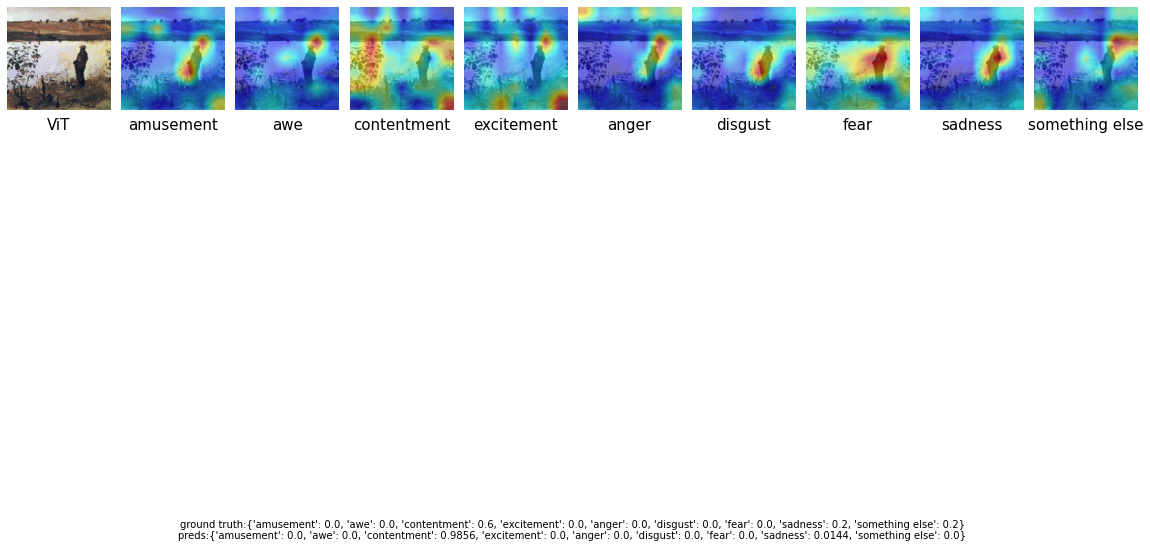

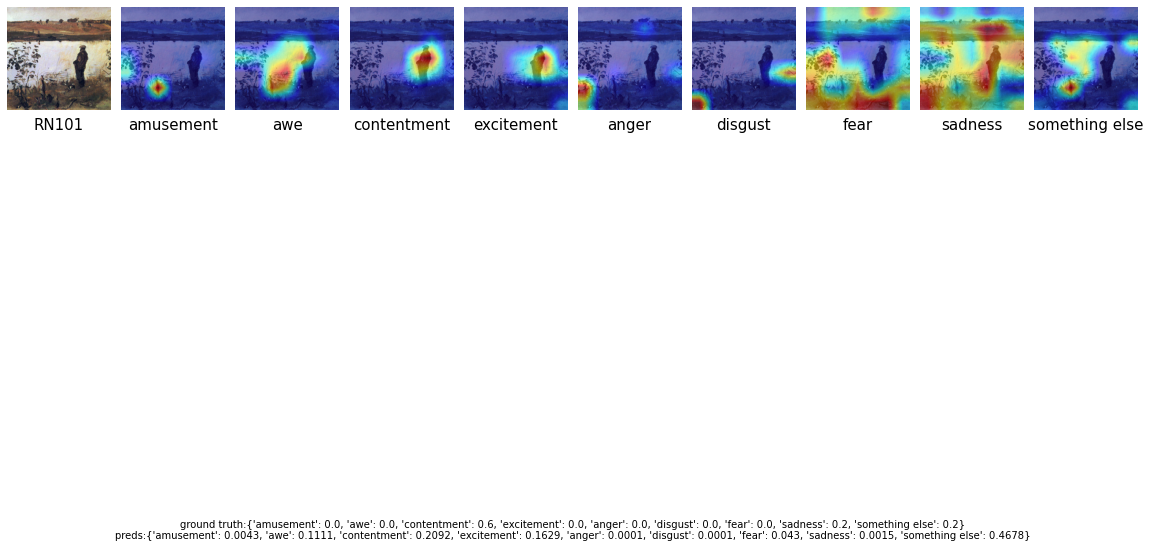

In [7]:
pp = PdfPages(res_dir+'artemis.pdf')

def tensor2img(tensor):
    tensor = tensor.detach().cpu()
    c = tensor-tensor.min()
    c /= c.max()
    return c.permute(1,2,0)

for id_, image in enumerate(image_list[:10]):
    
    image = image.unsqueeze(0).to(device)
    label_dict = {}
    for key, val in ARTEMIS_EMOTIONS.items():
        label_dict[key] = round(float(label_list[id_][val].item()), 4)

    for neg in [False]:
         
        for model_id, model_type in enumerate(model_types):
            

            plt.figure(figsize=(16, 16))
            
            plt.subplot(1,10,1)
            plt.axis('off')
            plt.tight_layout()
            plt.imshow(tensor2img(image[0]))
            
            caption = ""
            for key, val in label_dict.items():
                if val>0:
                    caption+=f"{key}:{round(float(val), 4)}\n"

            if neg==None: title = "\n overlapped  \n blue:neg, red: pos"
            elif neg==True: title = "\n negative \n blue: high, red: low"
            else: title = "\n positive \n blue:low, red:high"
            
            plt.title(model_type, **font, y=-0.25)


            subplot = 2
            scores = []

            for emotion, emotion_feature in emotion_dict.items():

                emotion_feature = torch.HalfTensor(emotion_feature).unsqueeze(dim=0).to(device)

                plt.subplot(1,10, subplot)
                plt.axis('off')
                plt.tight_layout()
                subplot+=1

                if model_type=="ViT":
                    score = similarity_score(model_vit, image, emotion_feature)
                    if not neg==None:

                        interpret_vit(image.type(model_vit.dtype), emotion_feature, model_vit.visual, device, neg_saliency=neg)
                    else:
                        interpret_vit_overlapped(image.type(model_vit.dtype), emotion_feature, model_vit.visual, device)

                else:
                    score = similarity_score(model_rn, image, emotion_feature)
                    if not neg==None:
                        interpret_rn(image.type(model_rn.dtype), emotion_feature, model_rn.visual, GradCAM, device, neg_saliency=neg)
                    else:
                        interpret_rn_overlapped(image.type(model_rn.dtype), emotion_feature, model_rn.visual, GradCAM, device)

                scores.append(score.item())

               
                plt.title(emotion, **font,y=-0.25)
                

            scores = torch.tensor(scores)
            scores = torch.nn.functional.softmax(scores)
            preds = {}
            for key, val in ARTEMIS_EMOTIONS.items():
                preds[key] = round(float(scores[val].item()), 4) 

            plt.figtext(0.5, 0.1, f'ground truth:{label_dict}\npreds:{preds}', wrap=True, verticalalignment='top', horizontalalignment='center', fontsize=10)
            plt.savefig(res_dir + f'{model_type}_{id_}.png')
            pp.savefig()
        
pp.close()

# Attention mean and variance for each emotion

In [8]:
img_ids = ['scary_painting_colorful.jpg', "artemis.jpg", "sad_woman.jpg", "sad_painting.jpg"]

/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


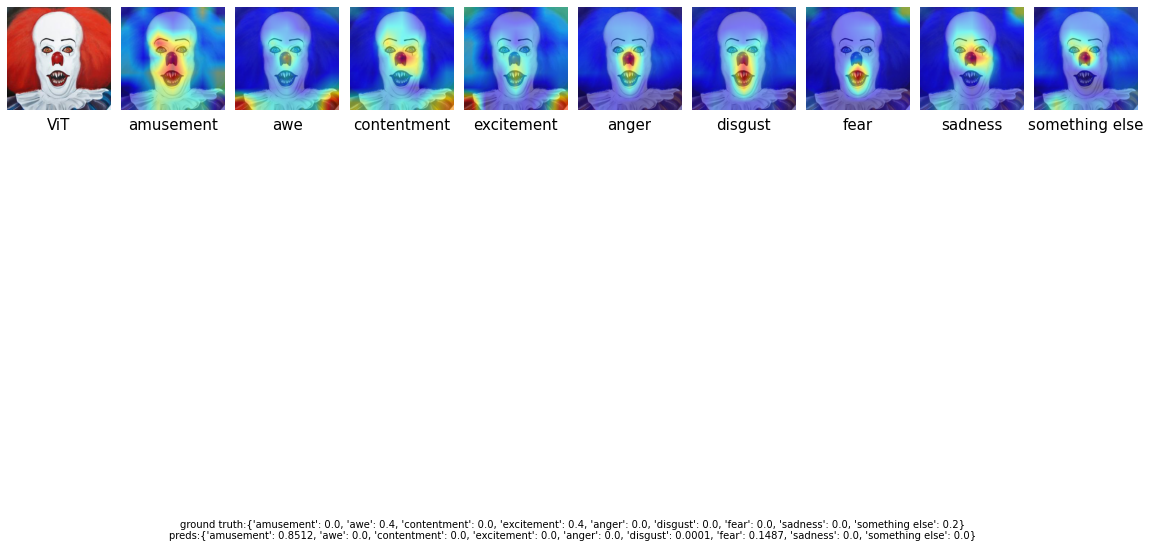

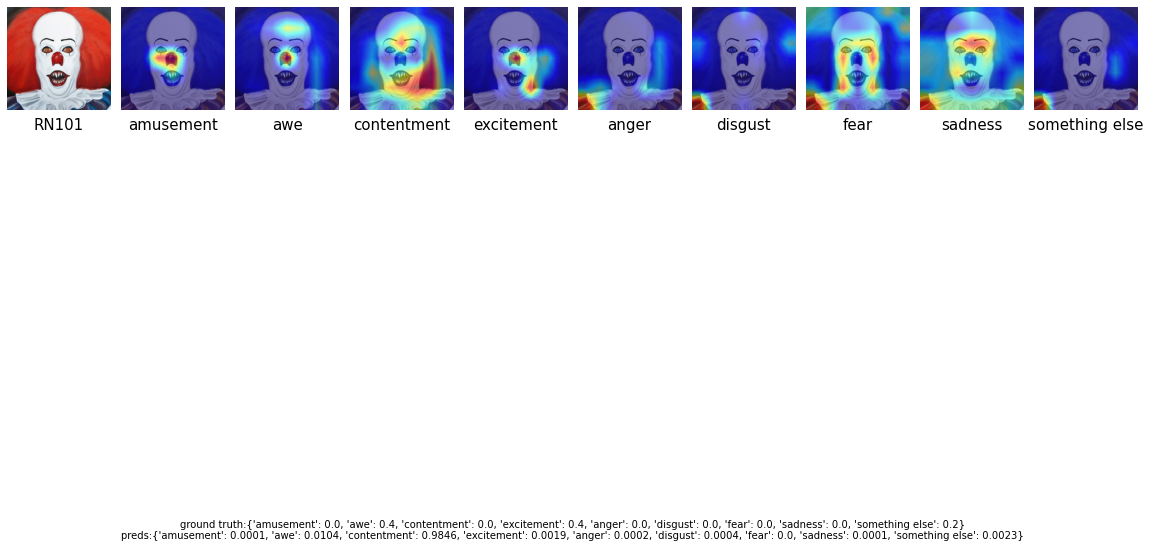

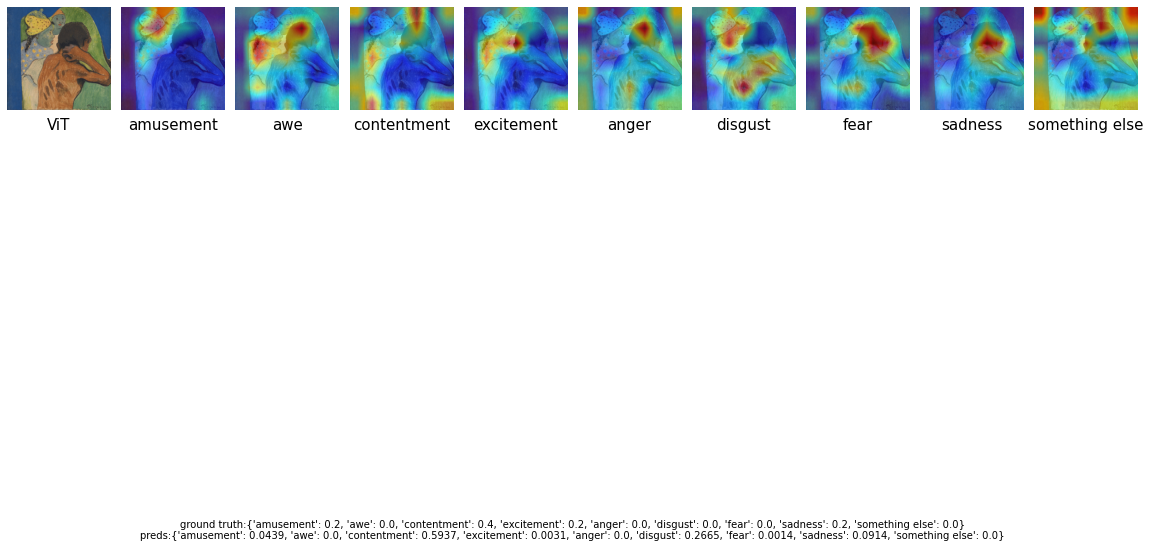

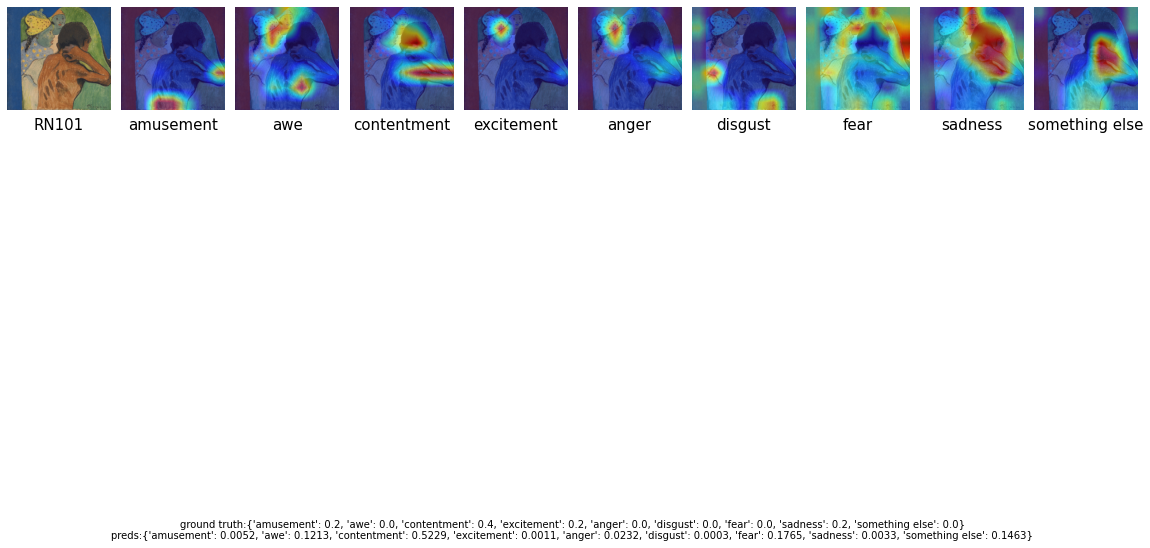

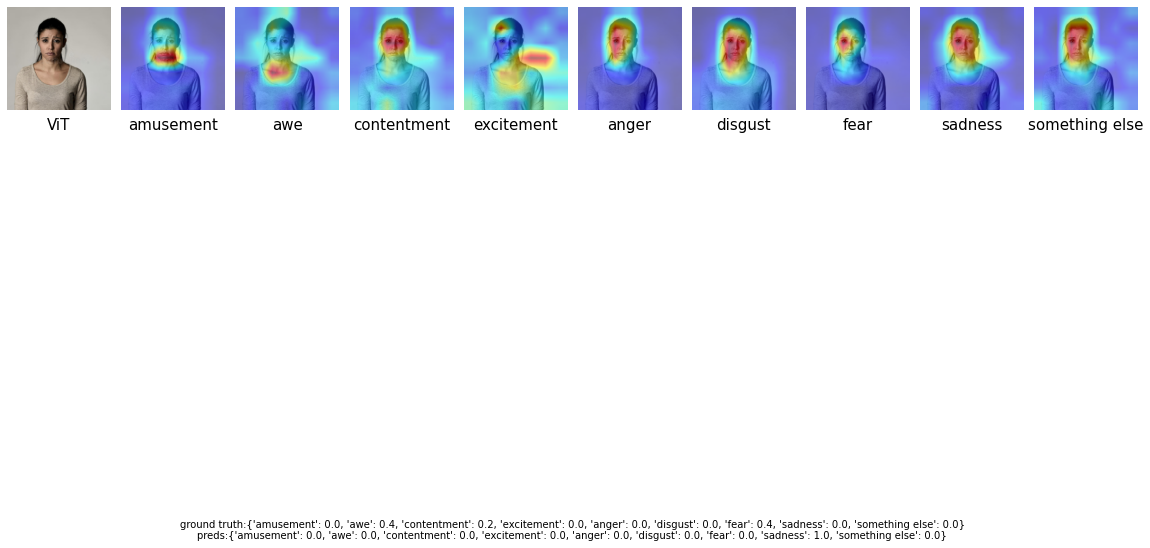

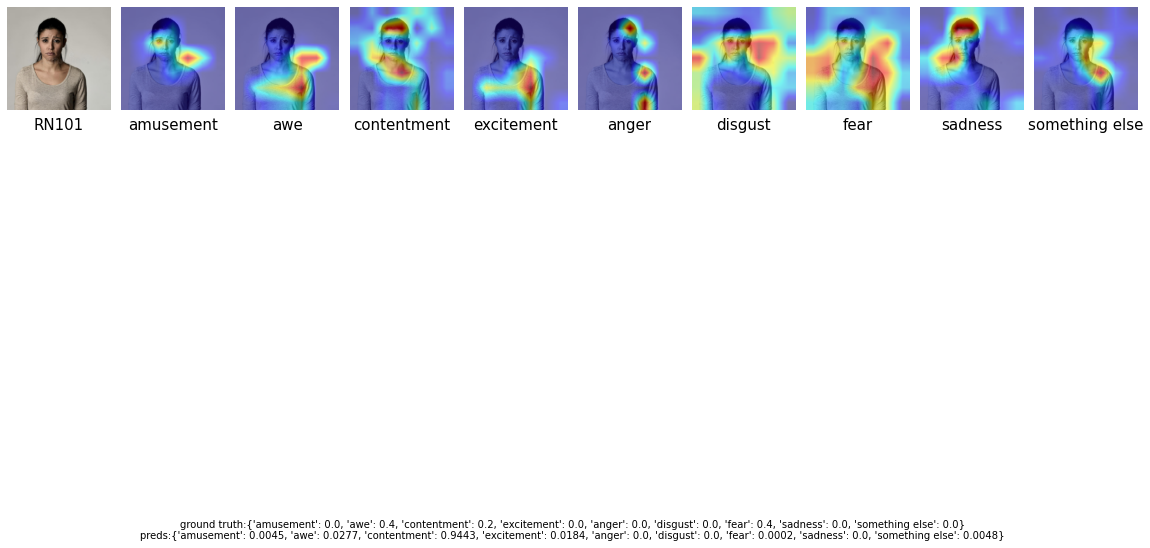

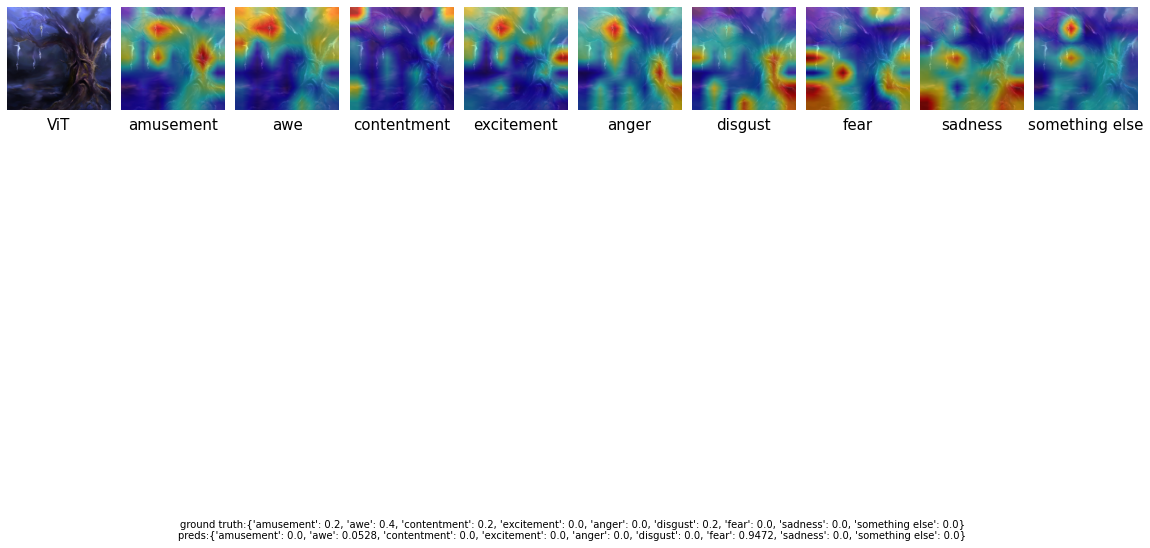

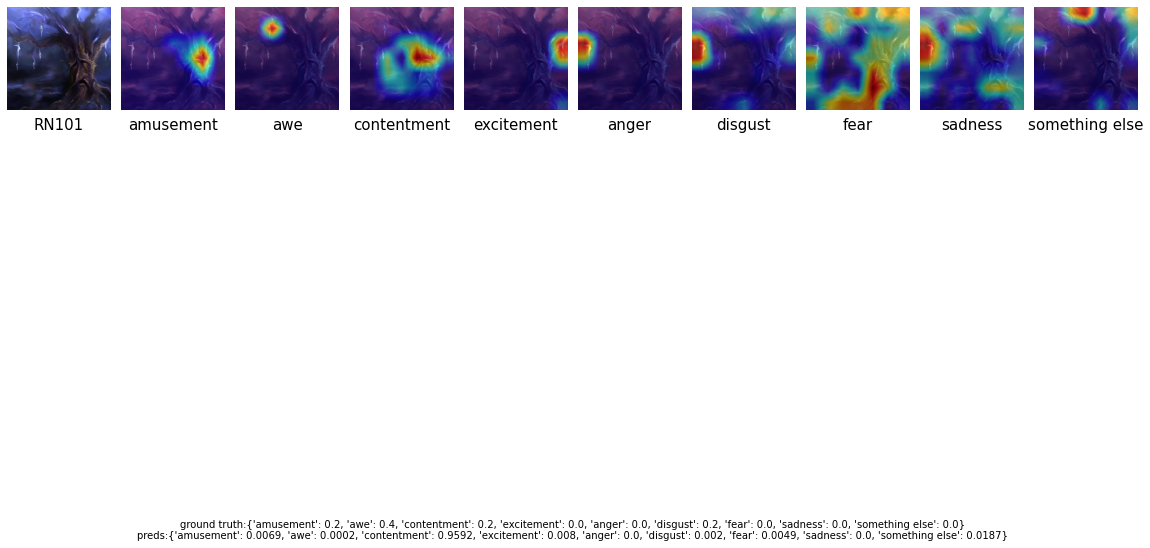

In [14]:
for id_, img_id in enumerate(img_ids):
    
    img_path =  os.path.join(root, img_id )
    image = ori_preprocess(Image.open(img_path))
    p_image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

    
    label_dict = {}
    for key, val in ARTEMIS_EMOTIONS.items():
        label_dict[key] = round(float(label_list[id_][val].item()), 4)

    for neg in [False]:
         
        for model_id, model_type in enumerate(model_types):
            

            plt.figure(figsize=(16, 16))
            plt.subplot(1,10,1)
            plt.tight_layout()
            plt.axis('off')
            plt.imshow(image.permute(1, 2, 0))
           
            
            caption = ""
            for key, val in label_dict.items():
                if val>0:
                    caption+=f"{key}:{round(float(val), 4)}\n"

            if neg==None: title = "\n overlapped  \n blue:neg, red: pos"
            elif neg==True: title = "\n negative \n blue: high, red: low"
            else: title = "\n positive \n blue:low, red:high"
            
            plt.title(model_type, **font, y=-0.25)


            subplot = 2
            scores = []

            for emotion, emotion_feature in emotion_dict.items():

                emotion_feature = torch.HalfTensor(emotion_feature).unsqueeze(dim=0).to(device)

                plt.subplot(1,10, subplot)
                plt.axis('off')
                plt.tight_layout()
                subplot+=1

                if model_type=="ViT":
                    score = similarity_score(model_vit, p_image, emotion_feature)
                    if not neg==None:

                        interpret_vit(p_image.type(model_vit.dtype), emotion_feature, model_vit.visual, device, neg_saliency=neg)
                    else:
                        interpret_vit_overlapped(p_image.type(model_vit.dtype), emotion_feature, model_vit.visual, device)

                else:
                    score = similarity_score(model_rn, p_image, emotion_feature)
                    if not neg==None:
                        interpret_rn(p_image.type(model_rn.dtype), emotion_feature, model_rn.visual, GradCAM, device, neg_saliency=neg)
                    else:
                        interpret_rn_overlapped(p_image.type(model_rn.dtype), emotion_feature, model_rn.visual, GradCAM, device)

                scores.append(score.item())

               
                plt.title(emotion, **font,y=-0.25)
                

            scores = torch.tensor(scores)
            scores = torch.nn.functional.softmax(scores)
            preds = {}
            for key, val in ARTEMIS_EMOTIONS.items():
                preds[key] = round(float(scores[val].item()), 4) 

            plt.figtext(0.5, 0.1, f'ground truth:{label_dict}\npreds:{preds}', wrap=True, verticalalignment='top', horizontalalignment='center', fontsize=10)
            plt.savefig(res_dir + f'{model_type}_{id_}.png')
          

In [16]:
image_loader = Pickle_data_loader(root+"wikiart/", 1000)
for i,batch in enumerate(image_loader):
    if i==0:
        image_list = batch["image"]
        label_list = batch["label"]
    else:
        image_list = torch.cat((image_list, batch["image"]), dim=0)
        label_list = torch.cat((label_list, batch["label"]), dim=0)

/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


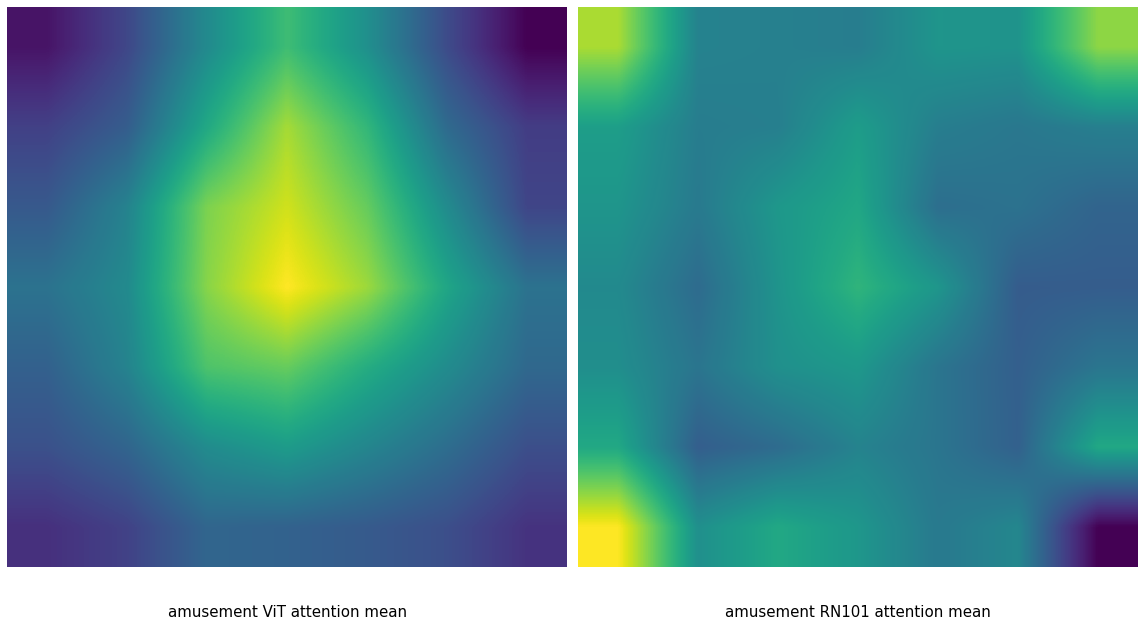

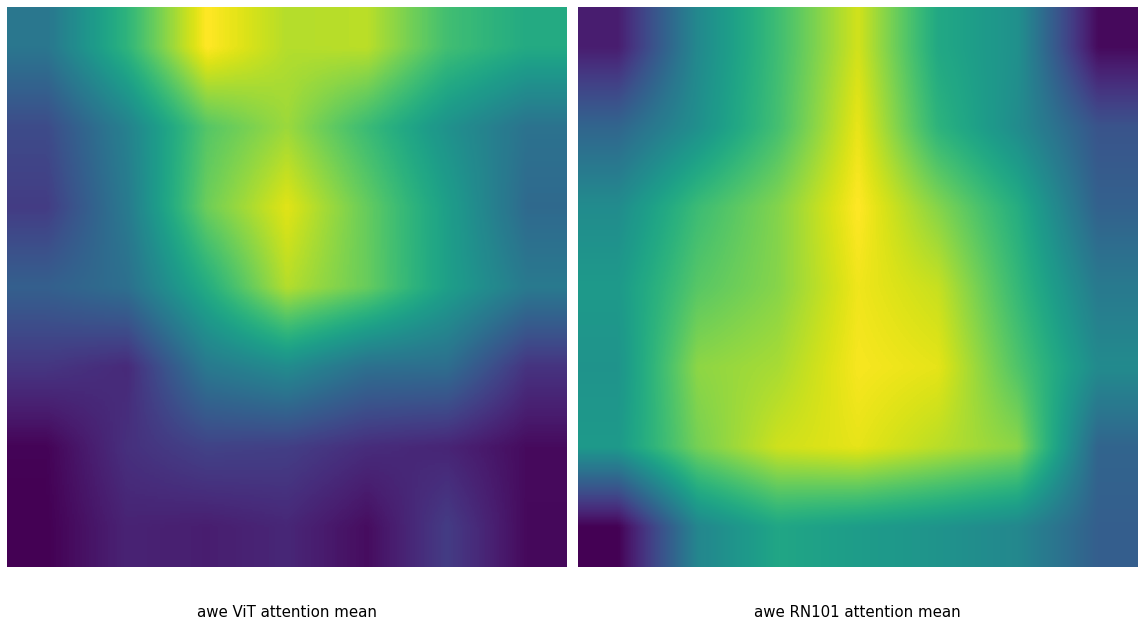

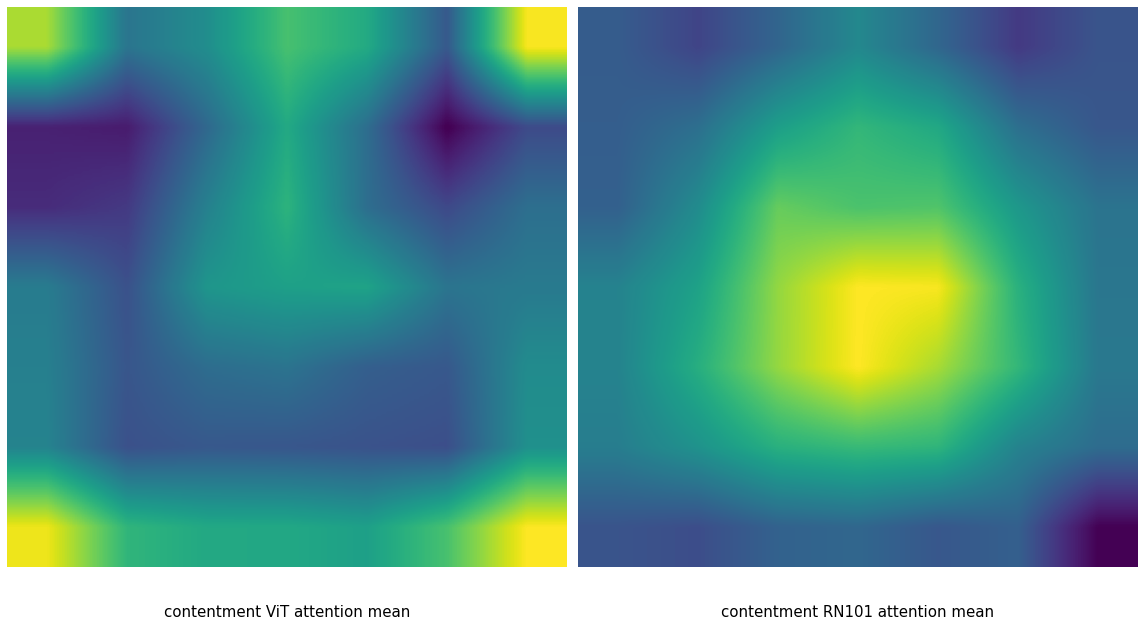

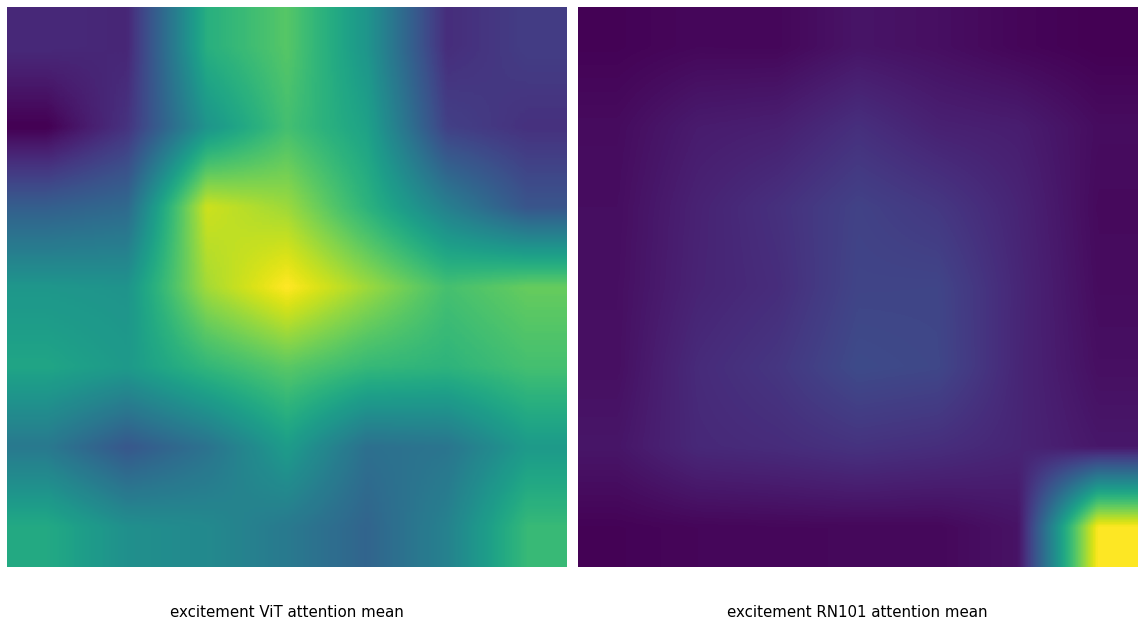

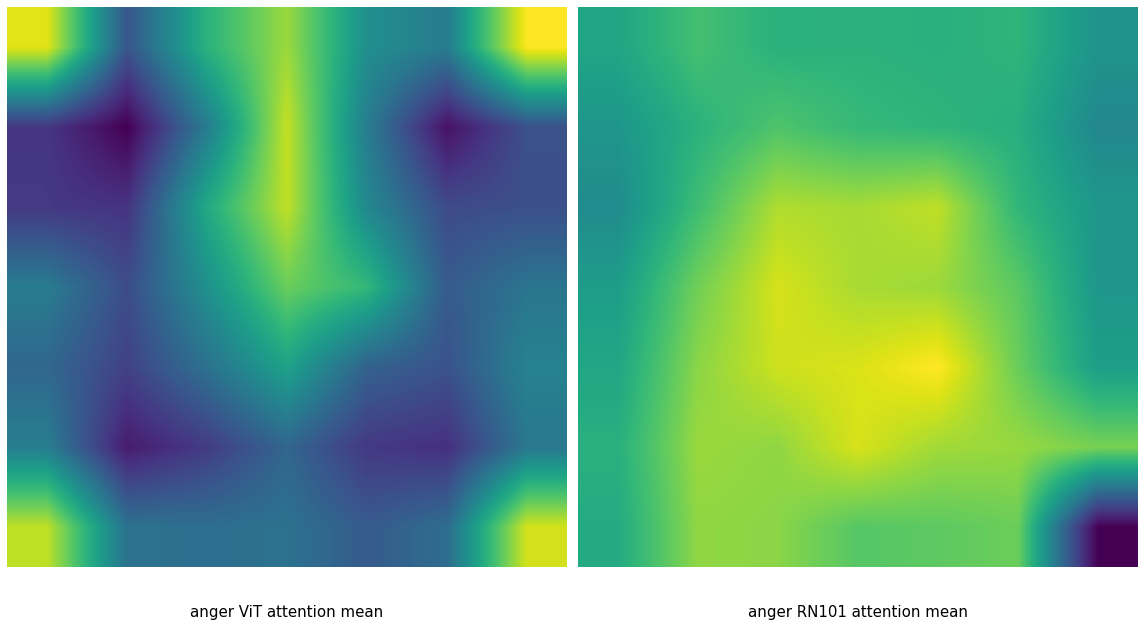

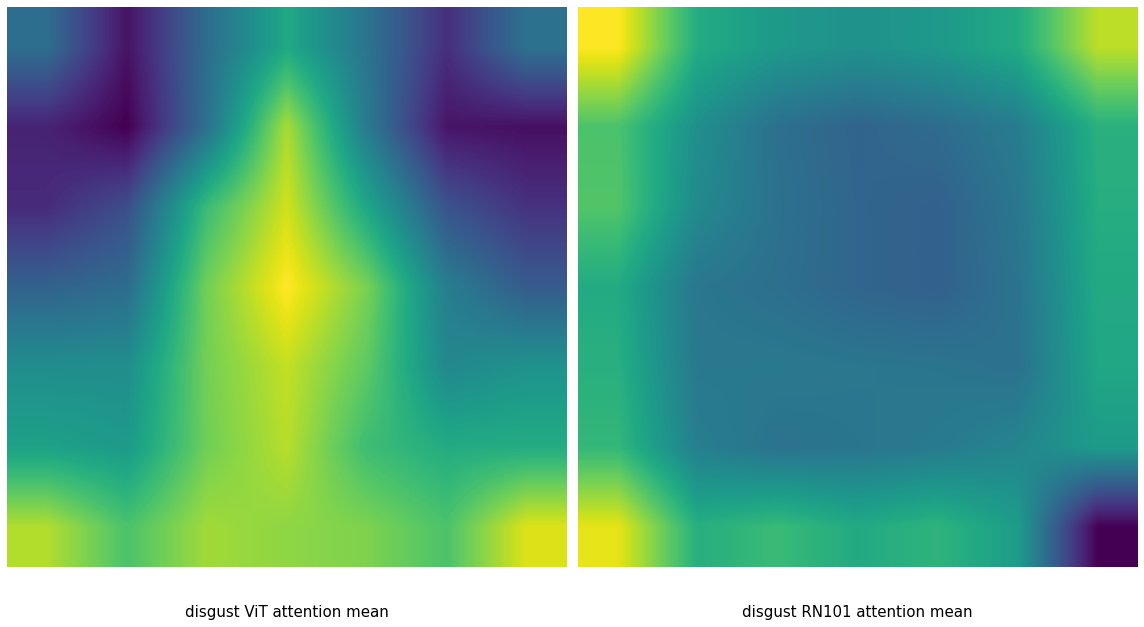

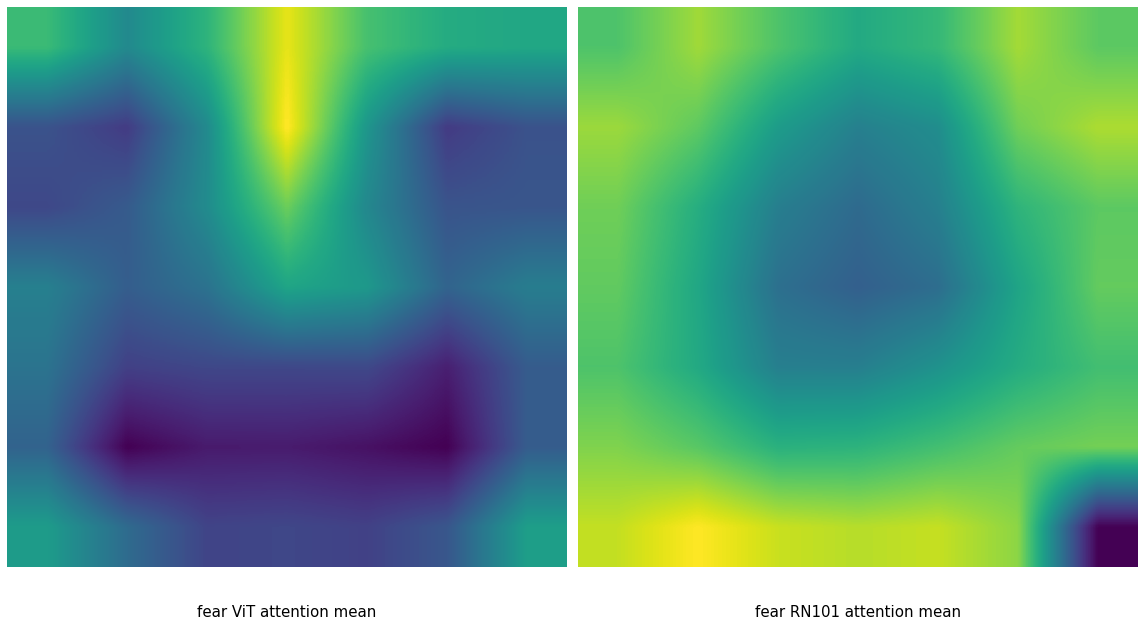

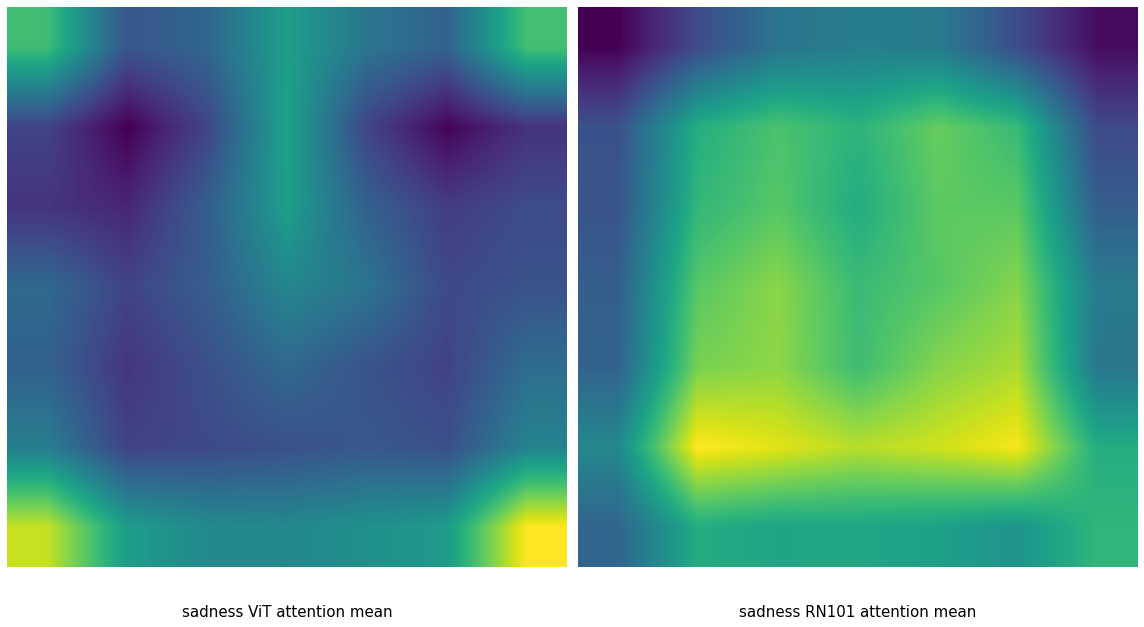

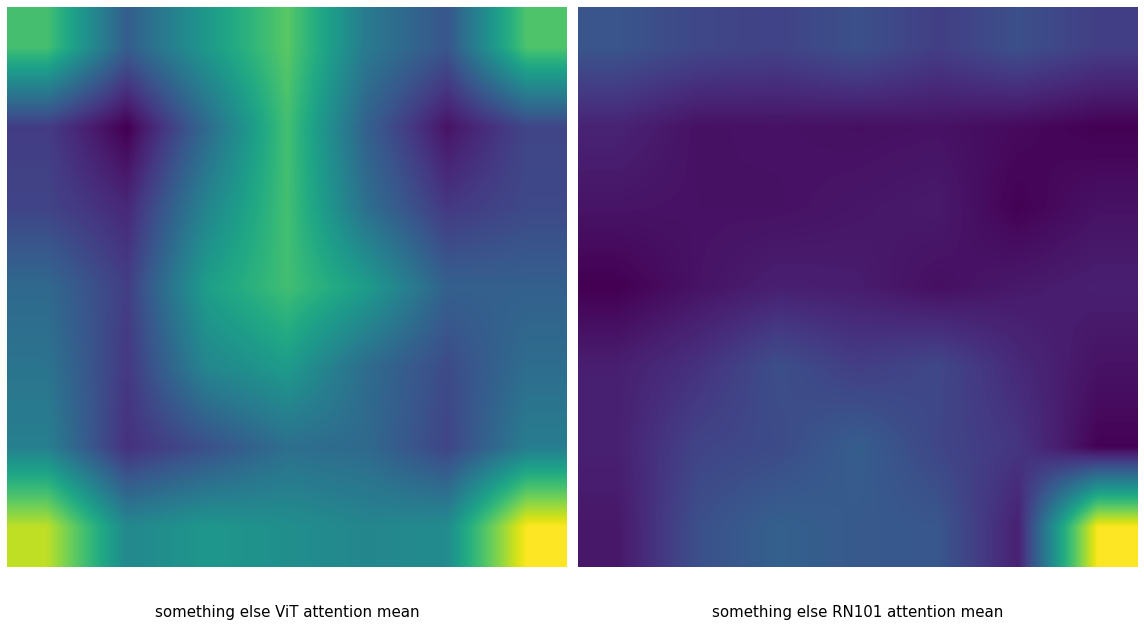

In [17]:
pp = PdfPages(res_dir+'artemis_bias.pdf')
for emotion, emotion_features in emotion_dict.items():
    
    emotion_features = torch.HalfTensor(emotion_features).unsqueeze(dim=0).to(device)
    var = []
    
    plt.figure(figsize=(16, 16)) 
    for model_id, model_type in enumerate(model_types):
        
        for id_, image in enumerate(image_list):

            image = image.unsqueeze(0).to(device)

            label_dict = {}
            for key, val in ARTEMIS_EMOTIONS.items():
                label_dict[key] = round(float(label_list[id_][val].item()), 4)

            
            if model_type=="ViT":
                relevance, _ = vit_relevance(image.type(model_vit.dtype), emotion_features, model_vit.visual, device)

            else:
                relevance, _ = rn_relevance(image.type(model_rn.dtype), emotion_features, model_rn.visual, GradCAM, device)

            relevance = np.expand_dims(relevance, axis=0)
           

            if id_ == 0:
                attentions = relevance
            else:
                attentions = np.concatenate((attentions, relevance), axis=0)


        mean = np.mean(attentions, axis=0)
        mean = np.float32(mean/np.max(mean))

        
        plt.subplot(1,2,1+model_id)
        plt.imshow(mean)
        plt.axis('off')
        plt.tight_layout()
        plt.title(emotion +" "+ model_type +" attention mean", **font,y=-0.10)
        
    plt.savefig(res_dir+emotion+'_mean.png')
    pp.savefig()
    
pp.close()